# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Imports and Utility Functions

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import os
from glob import glob

from utilityfun import *
from lanedetection import *

%load_ext autoreload
%autoreload 2

# Lane Finding Pipeline

## Camera Calibration

The first step is do do a camera calibration based on a set of images taken of a chess board at different angles and distances, where the number of squares is known.  OpenCV is capable of detecting the corners of these squares and then calculating a distortion matrix of the camera and lens based on their relative positions:

In [2]:
visualise = False
calibration_files = glob('./camera_cal/calibration*.jpg')

if visualise:
        %matplotlib qt
        
objpoints, imgpoints = calibration_corner_detection(calibration_files, visualise=visualise)

Calibrate the camera with the point detection routine in OpenCV:

In [3]:
# Camera calibration 
img = import_image('./camera_cal/calibration1.jpg')
img_res = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_res,None,None)
distortion_obj = {"mtx": mtx, "dist": dist}

Below is a preview of the effects of the camera calibration:

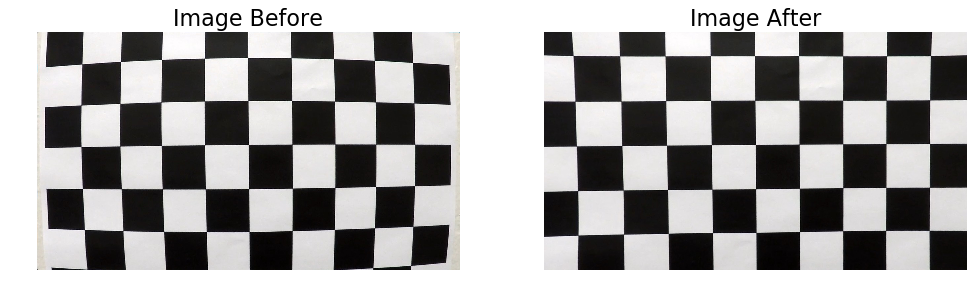

In [4]:
%matplotlib inline

# Test images:
udist = cv2.undistort(img, mtx, dist, None, mtx)
compare_images(img, udist)

Here we can see the dramatic distortion present in the images before calibration and how much of it was removed with the obtained distortion coefficients and camera matrix. It is nevertheless not 100% perfect, which is especially clear in the bottom left corner.

Now let's compare the images while driving:

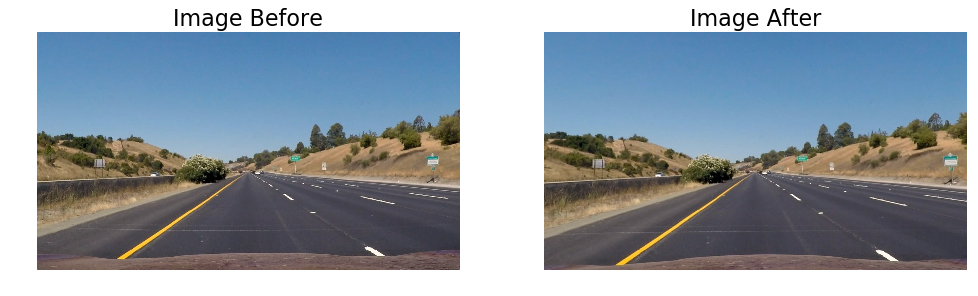

In [5]:
img = import_image('./test_images/straight_lines1.jpg')
udist = cv2.undistort(img, mtx, dist, None, mtx)
compare_images(img, udist)

With the real world images the difference is much more muted, which goes to show how well our perception masks these distortions.  The best place to see the difference is the hood, which is now pulled towards the centre of the frame near the middle.

## Perspective Transform

It was decided to perspective transform the image before doing any of the image processing to accentuate the lane lines, since this automatically restricts the transformations to the area of interest.

To transform the perspective of an image, we simply need four source points and their respective destination points. The perpective of an input image can then be modified to match these onto one another with the OpenCV function **`warpPerspective`**.

In [6]:
"""Tune source points to ensure that lane lines run vertically for a straight piece of road. """

src_top_left  = [0.408 * img_res[0], 0.65 * img_res[1]]
src_top_right = [0.592 * img_res[0], 0.65 * img_res[1]]
src_bot_left  = [0.000 * img_res[0], 0.95 * img_res[1]]
src_bot_right = [1.000 * img_res[0], 0.95 * img_res[1]]

src_points = np.float32([src_top_left, src_top_right, src_bot_left, src_bot_right])

In [7]:
"""Tune source points to ensure that lane lines run vertically for a straight piece of road. """

src_top_left  = [0.000 * img_res[0], 0.63 * img_res[1]]
src_top_right = [1.000 * img_res[0], 0.63 * img_res[1]]
src_bot_left  = [-3.08 * img_res[0], 0.95 * img_res[1]]
src_bot_right = [4.080 * img_res[0], 0.95 * img_res[1]]

src_points = np.float32([src_top_left, src_top_right, src_bot_left, src_bot_right])

Below is an example of a perspective transformed image, so that we obtain a bird's eye view of the road, as if perfectly above. The lane lines pass vertically from the bottom to the top. The points used to achieve this transformation were obtained by trial and error.

Here we see a slight curvature in the lanes, which appears to be some residual distortion remaining in the corrected image.

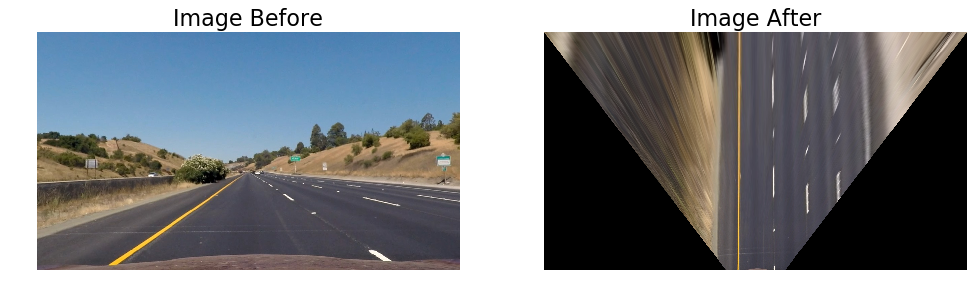

In [8]:
img = import_image('./test_images/straight_lines1.jpg')
udist = cv2.undistort(img, mtx, dist, None, mtx)
warped = perspective_transform(udist, src_points)
compare_images(udist, warped)
save_image(warped, name='perspective_transform')

## Process Image to Amplify Lane Markings

### Analyse colour channels

Plot the image and its color channels to identify features by which the lane lines can be identified.

Note: Input image must be in RGB color space!


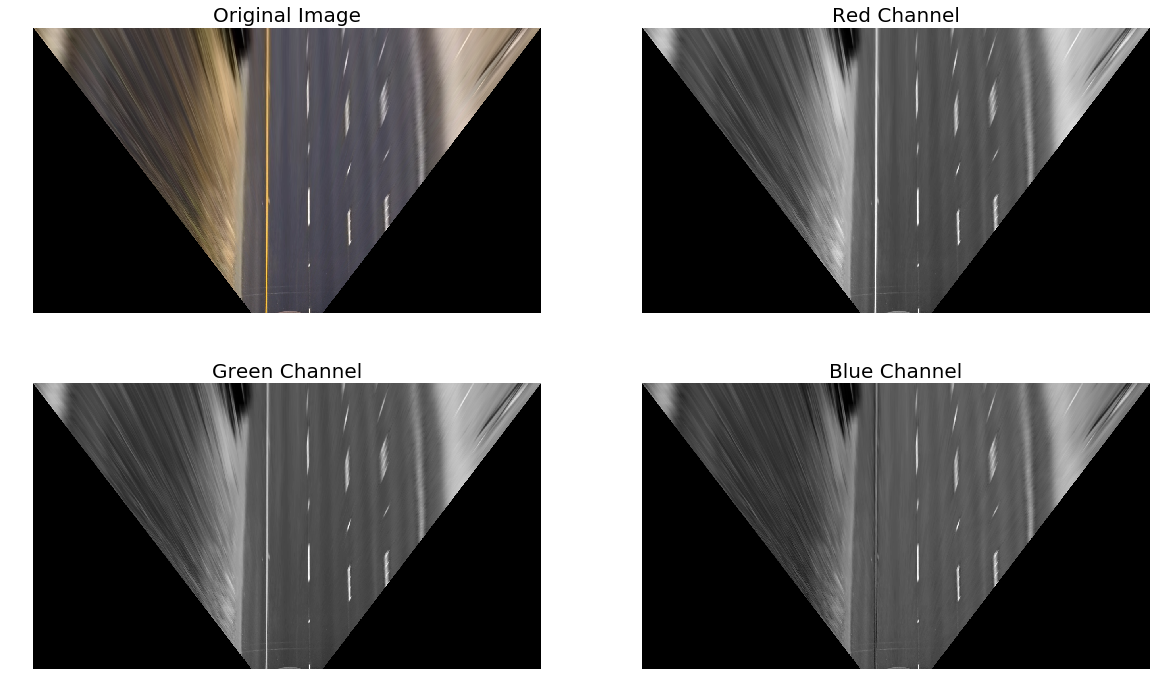

In [9]:
plot_color_channels(warped, colorspace='RGB')

When we look at the RGB decomposition, the information contained in each channel is not far off from what we would expect in a grayscale conversion.  Nevertheless, the red channel is more sensitive to the yellow lane marking, which is something we could use later. 

Note: Input image must be in RGB color space!


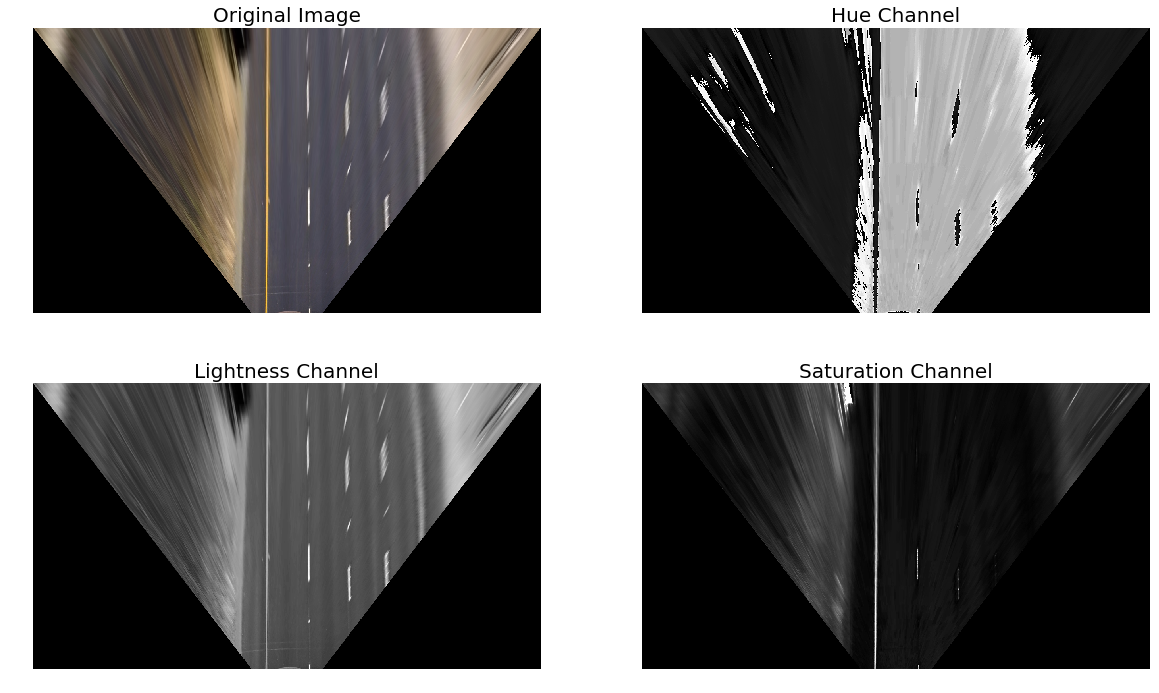

In [10]:
plot_color_channels(warped, colorspace='HLS')

In the HLS colourspace there are more pronounced differences.  The Hue channel does not have much value, although the saturation channel is quite sensitive to the lane markings.  Here the problem is that the performance can be unpredictable,  In the upper portion of the image  there are wild fluctualtions in the saturation.  

The disturbances are especially strong in the shade, which can have extremely high and low values. It was also found that the saturation for white lane markings could be quite unpredictable with either very high or very low values.

### Gradients

To detect strong gradients that can help us identify the near vertical lines we are trying to detect, a sobel filter in x is used.  For lane lines this should result in two peaks along the sides of each lane marking respectively, since here we expect a large color gradient.

We are using the red channel, since we saw before that this contains similar information to the grayscale image, but also accentuates the yellow lane markings.

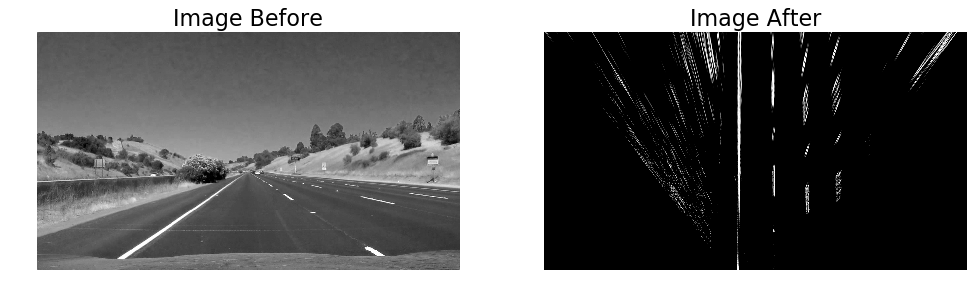

In [11]:
grad_binary = abs_sobel(udist[:,:,0], thresh_min=20)
warped_sobel = perspective_transform(grad_binary, src_points)
compare_images(img[:,:,0], warped_sobel)

## Image Augmentation

We have seen that there are various techniques to process the input images to accentuate the lane markings.  However, none of these works for all sitations.  To address this, we need to create an ensemble, where the lanes are accentuated, but all other road features and disturbances are reduced.

To detect the lanes, we will limit our search to the central portion of the image.

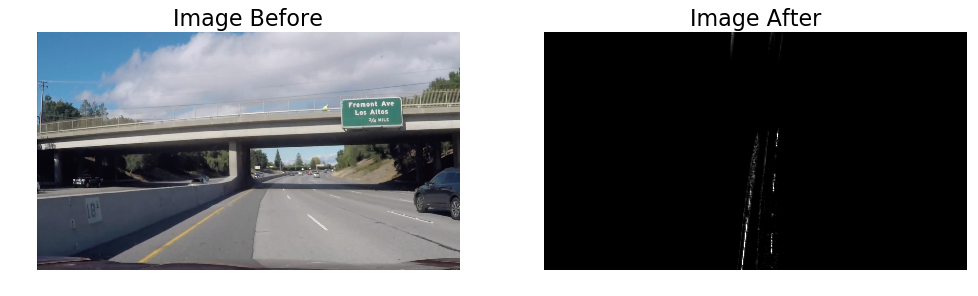

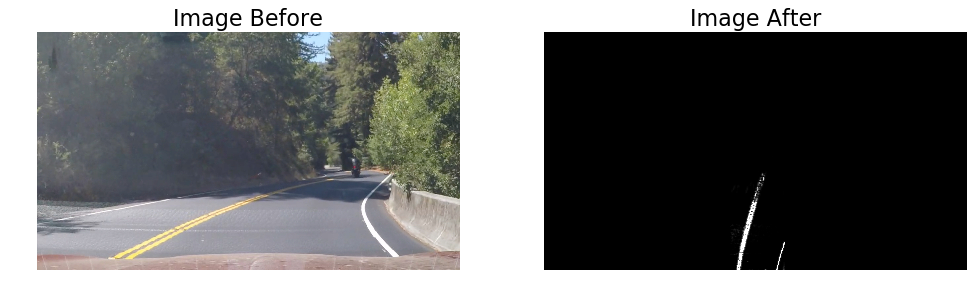

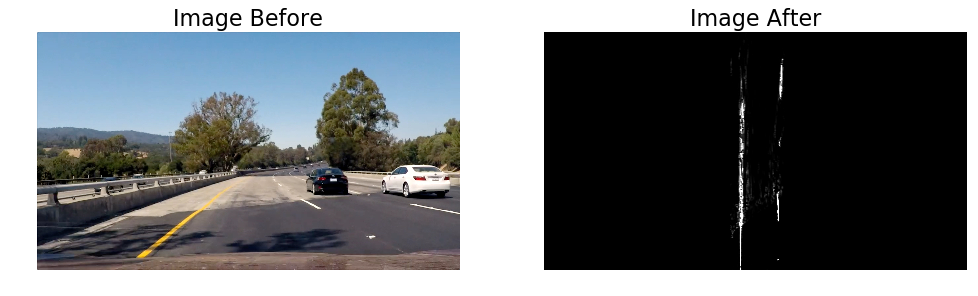

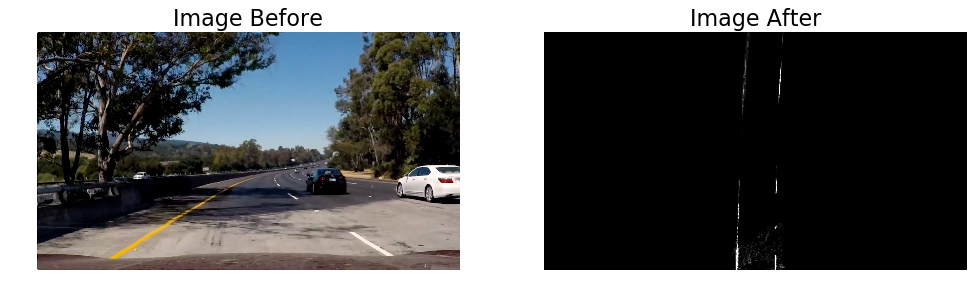

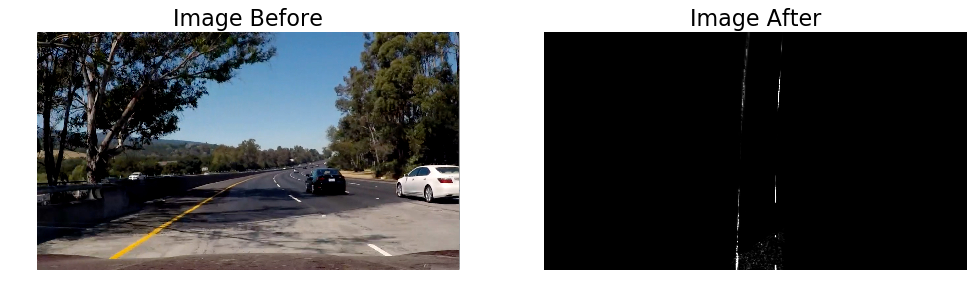

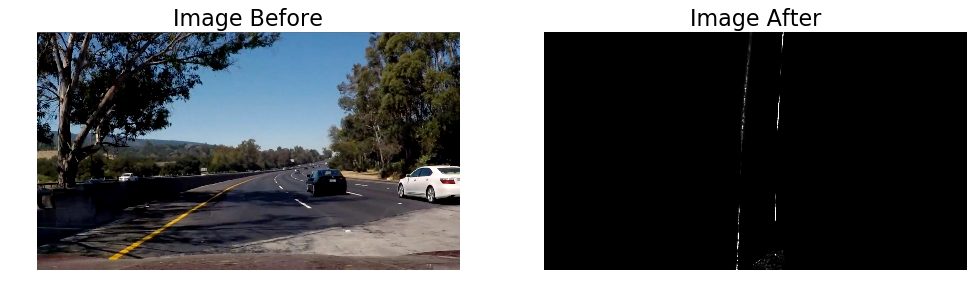

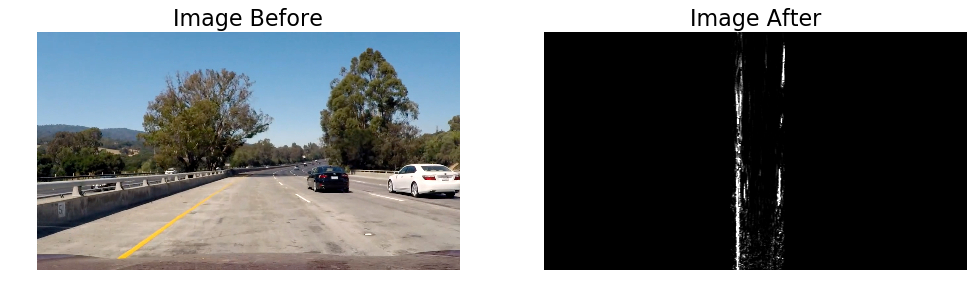

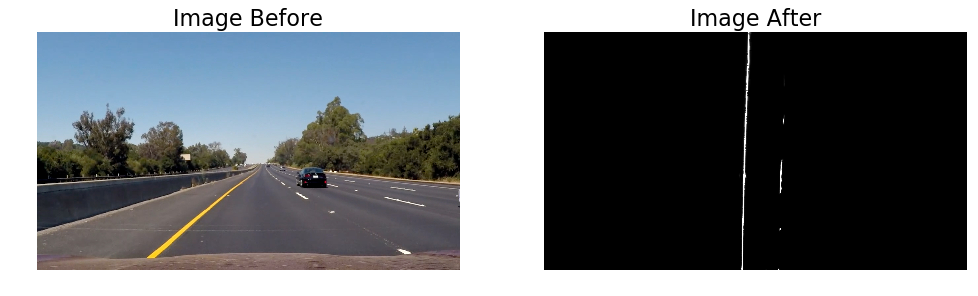

In [52]:
test_image_files = glob('./tough_ones/*.jpg')

aoi = ((int(0.44 * 1280), int(0.0 * 720)),
       (int(0.57 * 1280), int(1.0 * 720))) #area of interest

for test_image_file in test_image_files:
    test_image = import_image(test_image_file)
    
    udist = cv2.undistort(test_image, mtx, dist, None, mtx)
    warped = perspective_transform(udist, src_points)
    accentuated = np.zeros((warped.shape[0], warped.shape[1]))
    accentuated[aoi[0][1]:aoi[1][1], aoi[0][0]:aoi[1][0]] = accentuate_lane_lines(warped[aoi[0][1]:aoi[1][1], 
                                                                                         aoi[0][0]:aoi[1][0],
                                                                                         :])
    compare_images(test_image, accentuated)

## Detect Lane Lines

In the next step, the lane lines need to be detected. For this we first subdivide the image into vertical bins. We will then try to detect the lane position for each slice.

In [53]:
test_image = import_image('./tough_ones/tricky6.jpg')

    
udist = cv2.undistort(test_image, mtx, dist, None, mtx)
warped = perspective_transform(udist, src_points)
accentuated = np.zeros((warped.shape[0], warped.shape[1]))
accentuated[aoi[0][1]:aoi[1][1], aoi[0][0]:aoi[1][0]] = accentuate_lane_lines(warped[aoi[0][1]:aoi[1][1], 
                                                                                     aoi[0][0]:aoi[1][0],
                                                                                     :])

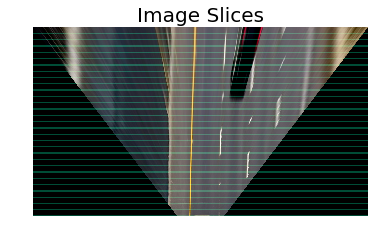

In [54]:
vertical_bins = range(30)
image_height = 720 #px
vertical_bins = [int(24 * 1) for b in vertical_bins]

visualise_bins(warped, vertical_bins)

Now we need to detect the intensity peaks in the input images. This is done for each side respectively. For the first image in a series, all pixels to the left of the centre of the image are considered for the left lane and all pixels to the right of the centre are considered for the right lane. Once a polynomial exists, it is expected that its shape wont change too dramatically between frames, therefore the search window is reduced to within 50px either side of the existing polynomials respectively.  This has the added advantage of allowing lane lines to cross over the center line in sharp corners. Once the windows of interest move outside of the image, the search windows are fixed at the side of the image.

The peaks are detected by getting the maximum value from the histogram and comparing it to the average over the histogram. Based on this a confidence score is retuned along with the detected peak position.

If a polynomial approximation of the left and/or right lane markings is supplied from a previous frame, the search is limited to a localised width near the polynomial, since it is not expected that the lane line position will change dramatically from one frame to the next. This technique is also powerful because it would track lane lines even when they pass through the center of the image.

The histogram is based on scaled pixel values. These are scaled by an exponential factor to put a higher weighting in pixels which are close to white. The associated confidence values were determined by trial and error.

To ensure that the projections are accurate, plot the result on an image below. The dots are colored by confidence level:

| Color | Confidence Level |
|:-----:|:----------------:|
| Green | High |
| Yellow | Medium |
| Orange | Low |
| Red | No Confidence |

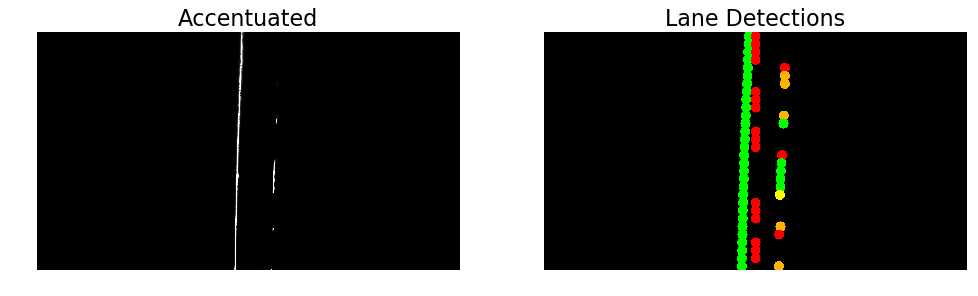

In [55]:
left_peaks, right_peaks = detect_lines(accentuated, vertical_bins)

# Create a 3-channel image from grayscale so colourful circles can be plotted on it.
norm_img_color = np.stack((accentuated, accentuated, accentuated), axis=-1)
img_peaks = np.copy(norm_img_color)

def mark_peak(img, peak_info):
    confidence = peak_info[2]
    if confidence == 'high':
        color = (0,255,0)
    elif confidence == 'medium':
        color = (255,255,0)
    elif confidence == 'low':
        color = (255,180,0)
    elif confidence == 'none':
        color = (255,0,0)
        
    return cv2.circle(img, (peak_info[0],peak_info[1]) , 15, color, -1)

for left_peak, right_peak in zip(left_peaks, right_peaks):
    img_peaks = mark_peak(img_peaks, left_peak)
    img_peaks = mark_peak(img_peaks, right_peak)
    
compare_images(accentuated, img_peaks.astype(int), titles=['Accentuated', 'Lane Detections'])

## Get Polynomial Approximations of Lanes

Get a polynomial that passes through all of the points that have a high or medium confidence:

Plot the polynomials that were detected on the warped image to check their accuracy:

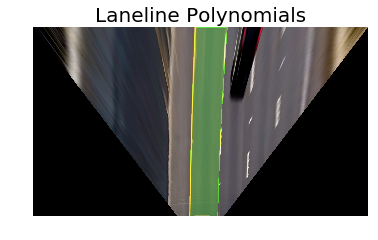

In [56]:
left_lane_poly, points_left = get_lane_poly(left_peaks)
right_lane_poly, points_right = get_lane_poly(right_peaks)

overlay_lines, overlay_fill = get_highlighted_lane(left_lane_poly, right_lane_poly, accentuated)
img_with_lanes = overlay_image(warped, overlay_fill, opacity=0.3)
img_with_lanes = overlay_image(img_with_lanes, overlay_lines, opacity=0.7)

plot_image(img_with_lanes, title='Laneline Polynomials')

## Get Curvature and Car Position

Convert the polynomial from pixel space to real world dimensions based on an expected lane width of 3.7 meters. The width of the lanes in pixel space is measured and fixed in this case because determining it dynamically was not seen as advantageous and likely to cause errors.

For the scaling in x, it is assumed that the width of the lane is 3.7m and the length of the dashed lines in 3.0m as per US regulations.

In [57]:
pixels_between_lanes = 110
pixels_along_dash = 90

mpp_x = 3.7/pixels_between_lanes #meters per pixel in x-direction
mpp_y = 3.0/pixels_along_dash #meters per pixel in y-direction

Transform the polynomial with more datapoints into real world dimensions.  This is expected to be the more reliable result.

In [58]:
coeff_scaling = [mpp_x / (mpp_y ** 2), (mpp_x/mpp_x), 1]

dominant_poly, lane = (left_lane_poly, 'left') if points_left > points_right else (right_lane_poly, 'right')
print('The ' + lane + ' lane has more data points.')
poly_real = [coeff * coeff_scaling[i] for i, coeff in enumerate(dominant_poly)]

The left lane has more data points.


Determine the radius of curvature near the car with the dominant polynomial. The radius is determined from the formula: 

$$R_{curve} = \frac{(1+(2Ay+B)^2)^{3/2}}{|2A|}$$

Where A and B are the polynomial coefficients in:

$$ x = A y^2 + B y + C $$

In [59]:
lane_radius, direction = get_lane_curvature(poly_real, warped.shape[0]*mpp_y)
lane_rad_string = "Radius: " + "{:1.2f}".format(lane_radius) + 'm to the ' + direction   

Determine the offset of the car from the center of the road (assuming the camera is mounted perfectly in the center):

In [60]:
car_offset, side = get_car_offset(dominant_poly, lane, warped.shape[0], warped.shape[1], 
                                  pixels_between_lanes, mpp_x)
car_pos_string = "Offset: " + "{:1.2f}".format(car_offset) + 'm to the ' + side 

Create an overlay image with the car offset:

In [61]:
overlay_offset = plot_car_offset_lines(warped, car_offset, mpp_x, side)

## Visual Output

Convert the overlay back to the original perspective:

In [62]:
# undistort lane detection annotations
overlays = ({'image': overlay_lines,  'opacity': 0.8},
            {'image': overlay_fill,   'opacity': 0.3},
            {'image': overlay_offset, 'opacity': 0.8},)

img_with_overlay = undistort_and_overlay(udist, src_points, overlays)

img_with_overlay = darken_bg(img_with_overlay, img.shape[0] - 40,  img.shape[0], 0, img.shape[1])
img_with_overlay = plot_text(img_with_overlay, lane_rad_string, 'left') 
img_with_overlay = plot_text(img_with_overlay, car_pos_string, 'right')

Plot result on the original image including the car's offset from the centre of the lane and the road curvature near the car.

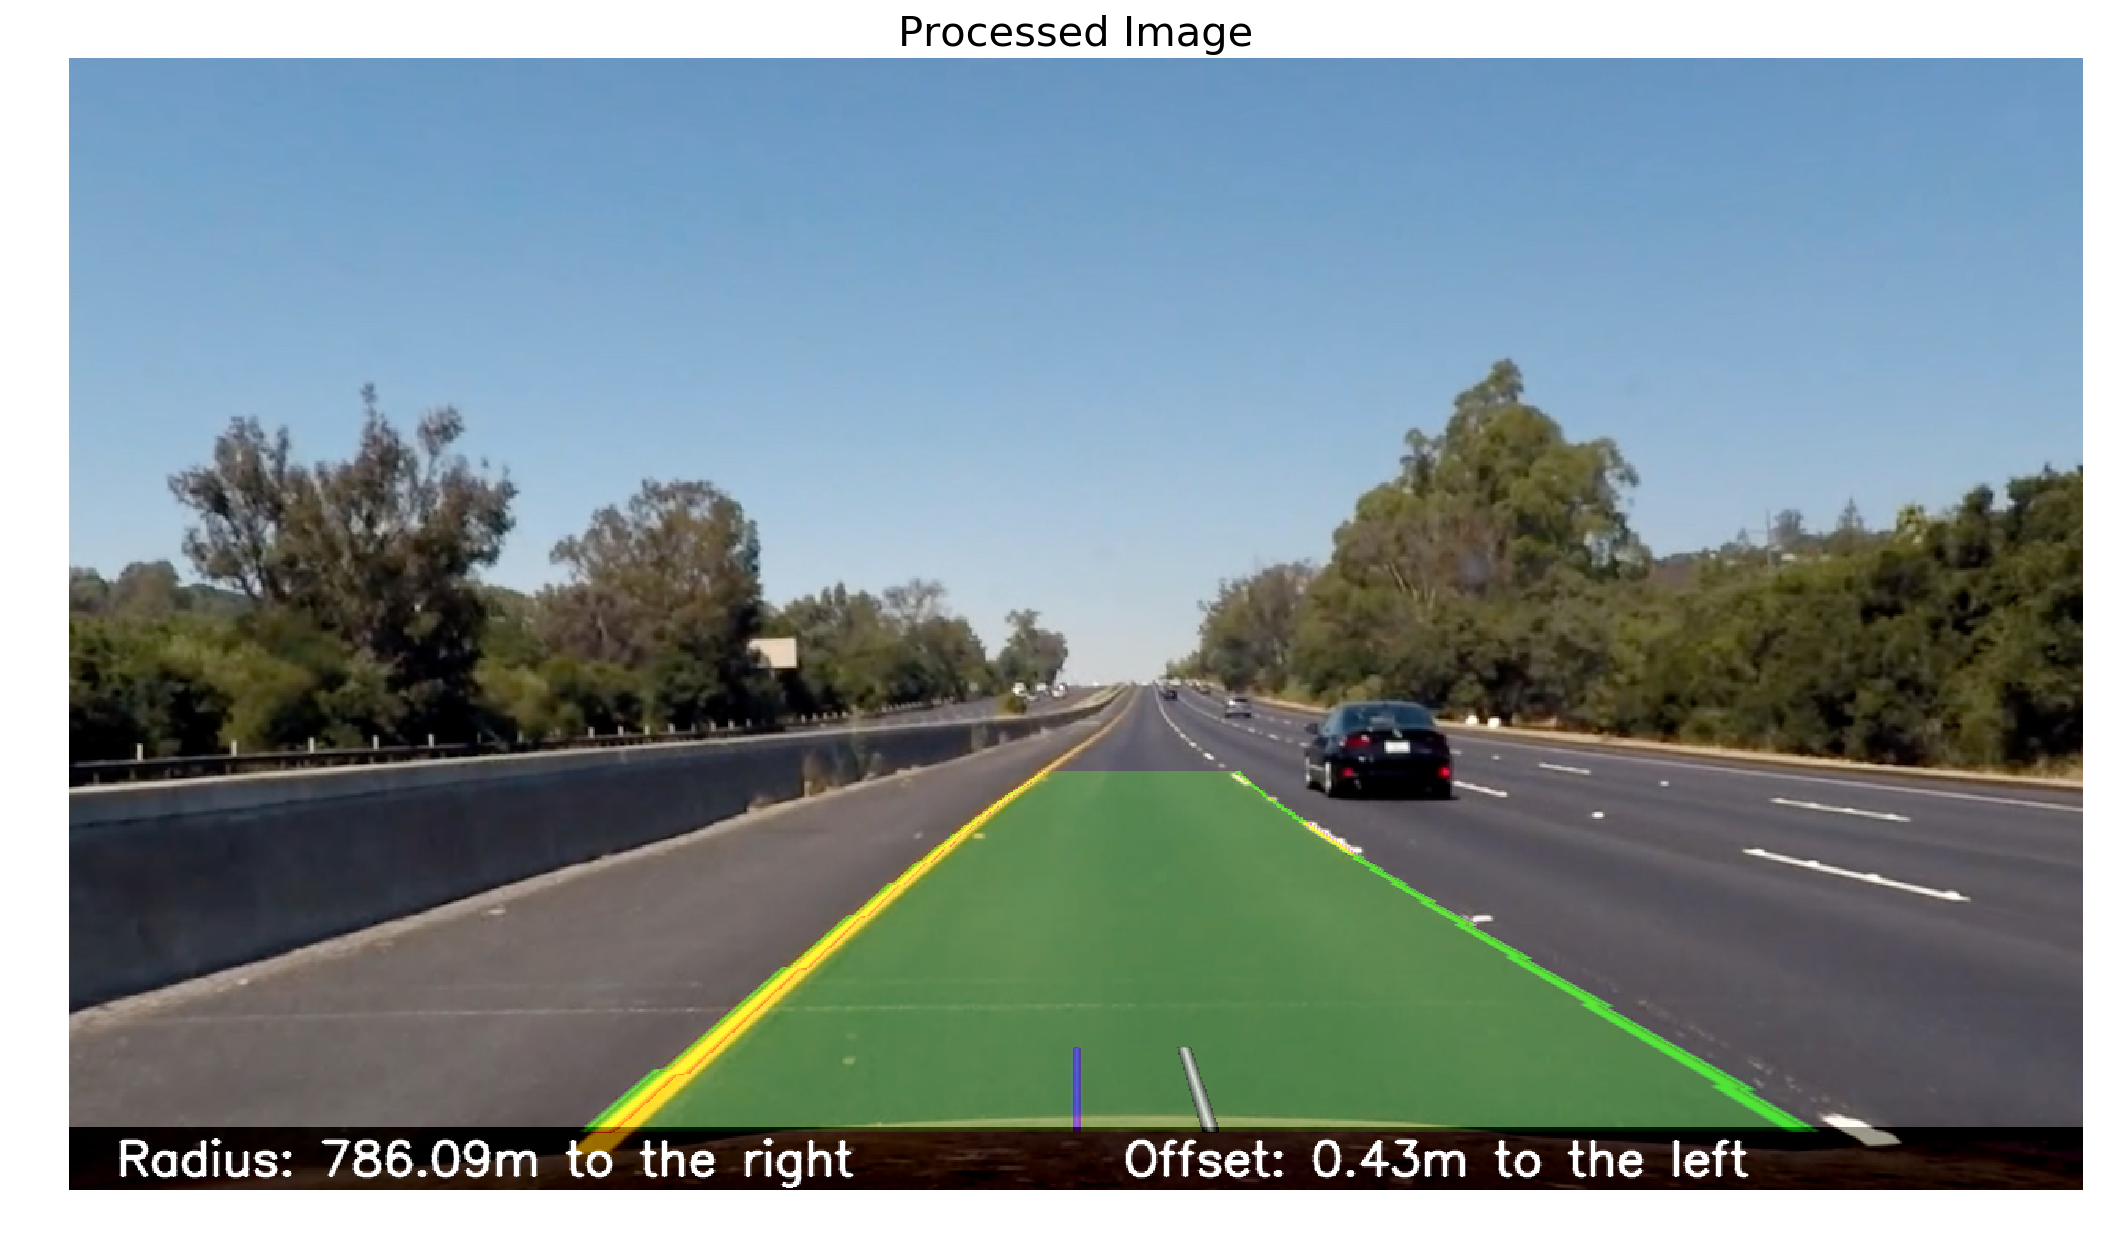

In [63]:
plt.subplots(1, 1, figsize=(20,10), dpi= 150)
plot_image(img_with_overlay.astype(int), title='Processed Image')

# Video Feeds - All Together Now

The full pipeline that takes an image or video frame as an input and gives the lane curvature, car position and annotated image as an output.

In [64]:
camera_setup = {'camera_matrix':        mtx
               ,'distortion_coeff':     dist
               ,'pixels_between_lanes': 110
               ,'pixels_along_dash':    90}

timing = {}
timing['image_manipulation'] = 0
timing['annotating_images'] = 0
timing['distortion_correction'] = 0
timing['perspective_transformations'] = 0
timing['polynomial_fitting'] = 0

Run pipeline on test images:

Time spent on image manipulation: 0.2 seconds.
Time spent on image annotation: 0.0 seconds.
Time spent on distortion correction: 0.1 seconds.
Time spent on perspective transformations: 2.5 seconds.
Time spent on polynomial fitting: 0.0 seconds.


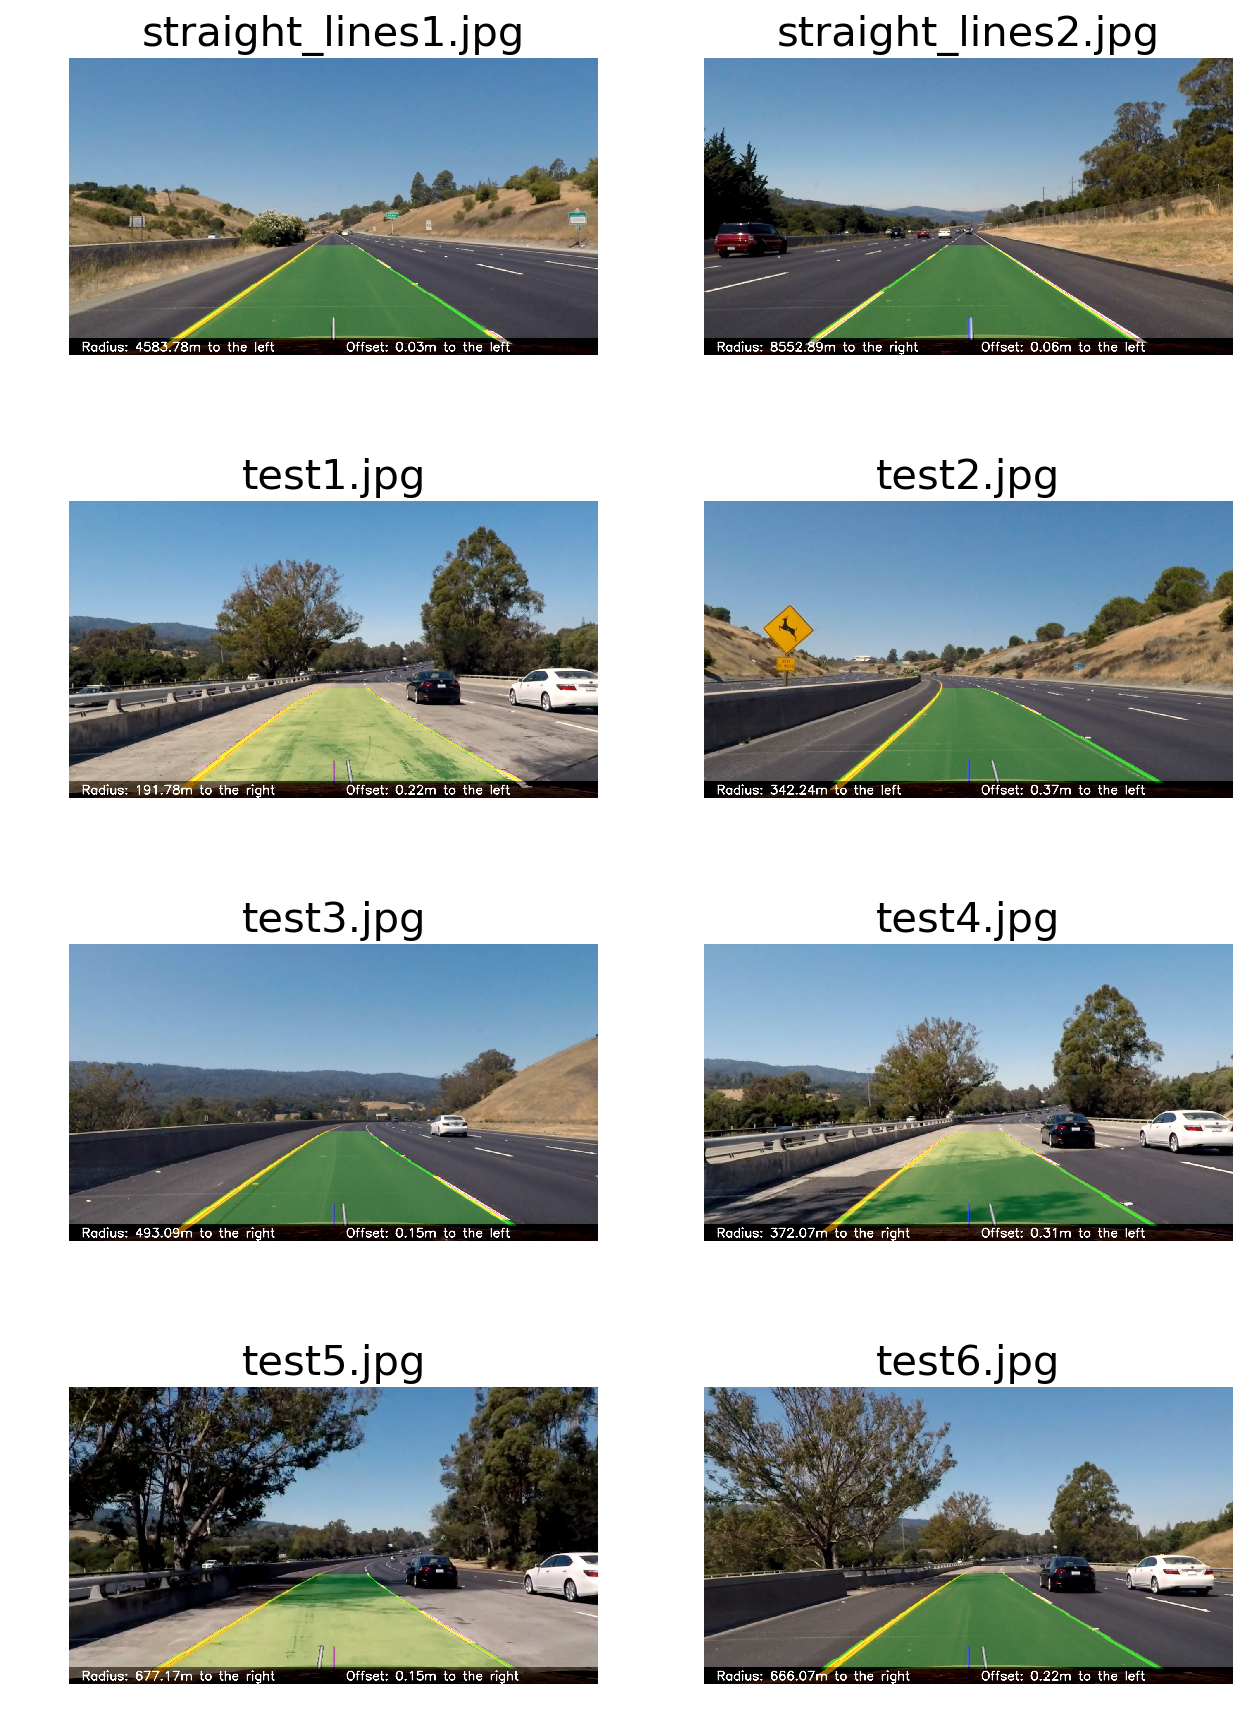

In [65]:
%matplotlib inline

dir = './test_images'
files = os.listdir(dir)

img_files = [dir + '/' + file for file in files if '.jpg' in file]

images = [import_image(image_file) for image_file in img_files]
p_l=None
p_r=None

plt.subplots(4, 2, figsize=(10, 15), dpi= 150)

for index, image in enumerate(images):
    img_name = img_files[index].split('/')[-1]
    img_result, p_l, p_r, timing = get_lane_info(image,
                                                 camera_setup,
                                                 src_points,
                                                 vertical_bins, timing)
    plt.subplot(4, 2, index + 1)
    plot_image(img_result.astype(int), title=img_name)
    
    
print('Time spent on image manipulation:', round(timing['image_manipulation'], 1), 'seconds.')
print('Time spent on image annotation:', round(timing['annotating_images'], 1), 'seconds.')
print('Time spent on distortion correction:', round(timing['distortion_correction'], 1), 'seconds.')
print('Time spent on perspective transformations:', round(timing['perspective_transformations'], 1), 'seconds.')
print('Time spent on polynomial fitting:', round(timing['polynomial_fitting'], 1), 'seconds.')


Feed video into pipeline:

In [66]:
import imageio

video_name = 'project_video'

reader = imageio.get_reader(video_name + '.mp4')
fps = reader.get_meta_data()['fps']

video_output = 'output_video/annotated_' + video_name + '.mp4'
writer = imageio.get_writer(video_output, fps=fps)

p_l=None
p_r=None

for image in reader:
    img_result, p_l, p_r, timing = get_lane_info(image, 
                                                 camera_setup, 
                                                 src_points,
                                                 vertical_bins,
                                                 timing, poly_left=p_l, poly_right=p_r)
    writer.append_data(img_result.astype(np.dtype('uint8')))
writer.close()

print('Time spent on image manipulation:', round(timing['image_manipulation'], 1), 'seconds.')
print('Time spent on image annotation:', round(timing['annotating_images'], 1), 'seconds.')
print('Time spent on distortion correction:', round(timing['distortion_correction'], 1), 'seconds.')
print('Time spent on perspective transformations:', round(timing['perspective_transformations'], 1), 'seconds.')
print('Time spent on polynomial fitting:', round(timing['polynomial_fitting'], 1), 'seconds.')

Right
Time spent on image manipulation: 23.6 seconds.
Time spent on image annotation: 3.0 seconds.
Time spent on distortion correction: 17.2 seconds.
Time spent on perspective transformations: 389.8 seconds.
Time spent on polynomial fitting: 5.3 seconds.


The resulting video can be found [here]('/output_videos/project_video_annotated.mp4').

# Discussion

While the resulting lane detection works relatively well, the curvature estimation is strongly reliant on the solid line on the left, since this gives a reliable polynomial approximation. The dashed lines on the right can be quite unpredictable, especially near shadows and low contrast road markings.

Another critical issue is performance. The current pipeline does not work anywhere close to realtime. To improve this, the performance of the code was profiled to see...

In [ ]:
plt.subplots(1, 1, figsize=(10,5), dpi= 150)
plot_image(img_result.astype(int), title=img_name)